## Embedding creation

Here we generate the embeddings (idk probably we can add more noise or do it differently)

In [34]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
from itertools import product
import numpy as np
import pandas as pd
import os
import openai
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [35]:
def generate_meetings_gmm_employees(
    n_meetings,
    n_employees=5,
    embedding_dim=128,
    samples_per_meeting=5,
    random_state=0,
):
    rng = np.random.default_rng(random_state)

    # Employee = GMM component 
    means = rng.normal(0, 10, size=(n_employees, embedding_dim))
    scales = rng.uniform(2,3, size=(n_employees, embedding_dim))

    for k in range(len(means)):
        mu = means[k]
        var = scales[k] ** 2

        print(f"\nEmployee {k}")
        print("Mean (first 5 dims):", mu[:5])
        print("Variance (first 5 dims):", var[:5])
        print("Average variance:", var.mean())



    # Mixture weights
    mixture_weights = rng.random(n_employees)
    mixture_weights /= mixture_weights.sum()

    rows = []

    for m in range(n_meetings):
        embeddings = []
        employee_ids = []

        for _ in range(samples_per_meeting):
            # sample employee
            z = rng.choice(n_employees, p=mixture_weights)
            x = rng.normal(means[z], scales[z])

            embeddings.append(x)
            employee_ids.append(z)

        rows.append({
            "meeting_id": m,
            "embeddings": np.stack(embeddings),   # (samples_per_meeting, embedding_dim)
            "employee_id": employee_ids,          # ground truth
        })

    df = pd.DataFrame(rows)
    return df, means, scales, mixture_weights

df, means, scales, mixture_weights = generate_meetings_gmm_employees(
    n_employees=5,
    embedding_dim=128,
    n_meetings=100
)

df.head()


Employee 0
Mean (first 5 dims): [ 1.25730221 -1.32104863  6.4042265   1.04900117 -5.35669373]
Variance (first 5 dims): [5.25671619 5.76357544 8.82356968 4.29073358 7.73565898]
Average variance: 6.353206400202424

Employee 1
Mean (first 5 dims): [ -5.68549454 -10.29804438 -10.4300108    2.6841708    3.58671949]
Variance (first 5 dims): [8.64794419 5.53105416 5.91040696 5.28313568 8.85803451]
Average variance: 6.4679928284637995

Employee 2
Mean (first 5 dims): [-6.67687292  1.63244006 -8.30751957 23.45808074 -7.04139562]
Variance (first 5 dims): [5.89974981 6.59140066 5.54474482 6.03439042 6.75639718]
Average variance: 6.184790620009972

Employee 3
Mean (first 5 dims): [ -7.96086775  -4.87218156  -9.75000119  -6.20429145 -10.04787219]
Variance (first 5 dims): [4.37082676 5.44449149 7.20587804 6.71180282 7.08692331]
Average variance: 6.340370332738226

Employee 4
Mean (first 5 dims): [-5.43957722 -1.33451559 12.97871761 -9.67819865 19.26662709]
Variance (first 5 dims): [6.01484197 7.782

,meeting_id,embeddings,employee_id
0,0,"[[-8.379317378558156, -6.73410503926509, -6.68...","[3, 0, 0, 0, 0]"
1,1,"[[-10.09371127833295, 5.32877435007231, -4.626...","[2, 4, 0, 0, 2]"
2,2,"[[-4.89777361964353, -10.46120071309339, -9.91...","[1, 0, 0, 4, 0]"
3,3,"[[-3.9952697012654608, 2.5629025170107598, -8....","[2, 1, 0, 0, 2]"
4,4,"[[-7.866729047216063, 3.021745374795121, -9.10...","[2, 1, 3, 4, 0]"


## Visualization

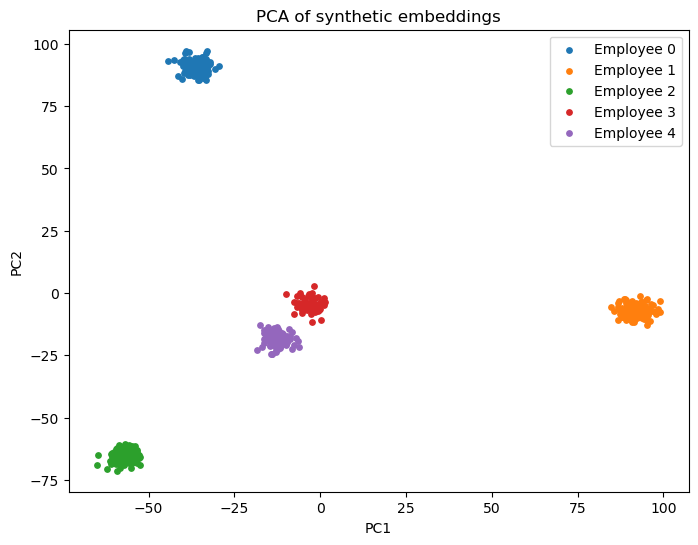

In [36]:
X = np.vstack(df["embeddings"].values)
y = np.hstack(df["employee_id"].values)

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

plt.figure(figsize=(8,6))

unique_employees = np.unique(y)

for emp in unique_employees:
    mask = y == emp
    plt.scatter(
        X2[mask, 0],
        X2[mask, 1],
        s=15,
        label=f"Employee {emp}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of synthetic embeddings")
plt.legend()
plt.show()

In [37]:
# distance between centers
center_dist = pdist(means).mean()

# average radius (std norm)
cluster_radius = np.mean(np.linalg.norm(scales, axis=1))

print(center_dist / cluster_radius)

5.576951508451627


## Generate tasks for each meeting for each employee

In [38]:
# helper function to generate combined tasks
def generate_tasks_from_components(part1, part2, part3, template, n_tasks=100):
    tasks = []
    for a, b, c in product(part1, part2, part3):
        tasks.append(template.format(a=a, b=b, c=c))
        if len(tasks) >= n_tasks:
            break
    return tasks

# definition of roles
roles = {
    1: "Doctor",
    2: "Nurse",
    3: "Lab Technician",
    4: "Pharmacist",
    5: "Administrator",
}

all_rows = []

# --- Doctor ---
part1 = ["Examine", "Diagnose", "Prescribe", "Consult", "Assess"]
part2 = ["patient vitals", "symptoms", "treatment plans", "medical history", "lab results"]
part3 = ["for cardiology patients", "for oncology patients", "for ICU patients",
         "for outpatient clinic", "for emergency cases"]
template = "{a} {b} {c}."
doctor_tasks = generate_tasks_from_components(part1, part2, part3, template)

for task in doctor_tasks:
    all_rows.append({
        "employee_id": 1,
        "role": roles[1],
        "task_description": task,
    })

# --- Nurse ---
part1 = ["Administer", "Monitor", "Assist", "Record", "Prepare"]
part2 = ["medication", "vital signs", "patient charts", "treatments", "equipment"]
part3 = ["for ICU patients", "for outpatient clinic", "for surgical ward",
         "for emergency cases", "for general ward"]
template = "{a} {b} {c}."
nurse_tasks = generate_tasks_from_components(part1, part2, part3, template)

for task in nurse_tasks:
    all_rows.append({
        "employee_id": 2,
        "role": roles[2],
        "task_description": task,
    })

# --- Lab Technician ---
part1 = ["Analyze", "Prepare", "Test", "Calibrate", "Report"]
part2 = ["blood samples", "urine tests", "pathology slides", "microbiology cultures", "diagnostic equipment"]
part3 = ["for ICU patients", "for routine check-ups", "for emergency cases",
         "for surgical patients", "for outpatient clinic"]
template = "{a} {b} {c}."
lab_tasks = generate_tasks_from_components(part1, part2, part3, template)

for task in lab_tasks:
    all_rows.append({
        "employee_id": 3,
        "role": roles[3],
        "task_description": task,
    })

# --- Pharmacist ---
part1 = ["Prepare", "Dispense", "Verify", "Review", "Document"]
part2 = ["prescriptions", "medication orders", "patient medication charts",
         "controlled substances", "inventory records"]
part3 = ["for high-risk patients", "for new admissions", "for outpatient clinic",
         "for ICU patients", "for emergency cases"]
template = "{a} {b} {c}."
pharmacist_tasks = generate_tasks_from_components(part1, part2, part3, template)

for task in pharmacist_tasks:
    all_rows.append({
        "employee_id": 4,
        "role": roles[4],
        "task_description": task,
    })

# --- Administrator ---
part1 = ["Update", "Organize", "Schedule", "Verify", "Record"]
part2 = ["patient records", "appointments", "billing information", "staff schedules", "insurance claims"]
part3 = ["for new admissions", "for outpatient clinic", "for inpatient wards",
         "for emergency cases", "for surgical procedures"]
template = "{a} {b} {c}."
admin_tasks = generate_tasks_from_components(part1, part2, part3, template)

for task in admin_tasks:
    all_rows.append({
        "employee_id": 5,
        "role": roles[5],
        "task_description": task,
    })

df_tasks_healthcare = pd.DataFrame(all_rows)

print(df_tasks_healthcare.head())
print("Totale righe:", len(df_tasks_healthcare))

csv_path = "healthcare_employee_tasks.csv"
df_tasks_healthcare.to_csv(csv_path, index=False)


   employee_id    role                                 task_description
0            1  Doctor  Examine patient vitals for cardiology patients.
1            1  Doctor    Examine patient vitals for oncology patients.
2            1  Doctor         Examine patient vitals for ICU patients.
3            1  Doctor    Examine patient vitals for outpatient clinic.
4            1  Doctor      Examine patient vitals for emergency cases.
Totale righe: 500


In [39]:
from itertools import product
import pandas as pd

# --- COMPONENTI CONDIVISE ---
shared_part1 = ["Review", "Update"]
shared_part2 = ["patient records", "medical reports"]
shared_part3 = ["for emergency cases", "for outpatient clinic"]

# definition of roles
roles = {
    1: "Doctor",
    2: "Nurse",
    3: "Lab Technician",
    4: "Pharmacist",
    5: "Administrator",
}

all_rows = []

def generate_tasks_from_components(part1, part2, part3, template, n_tasks=100):
    tasks = []
    for a, b, c in product(part1, part2, part3):
        tasks.append(template.format(a=a, b=b, c=c))
        if len(tasks) >= n_tasks:
            break
    return tasks

# --- Doctor ---
part1 = ["Examine", "Diagnose", "Prescribe"] + shared_part1
part2 = ["symptoms", "treatment plans"] + shared_part2
part3 = ["for cardiology patients", "for ICU patients"] + shared_part3

doctor_tasks = generate_tasks_from_components(part1, part2, part3, "{a} {b} {c}.")

for task in doctor_tasks:
    all_rows.append({
        "employee_id": 1,
        "role": roles[1],
        "task_description": task,
    })

# --- Nurse ---
part1 = ["Administer", "Monitor", "Assist"] + shared_part1
part2 = ["medication", "vital signs"] + shared_part2
part3 = ["for surgical ward", "for general ward"] + shared_part3

nurse_tasks = generate_tasks_from_components(part1, part2, part3, "{a} {b} {c}.")

for task in nurse_tasks:
    all_rows.append({
        "employee_id": 2,
        "role": roles[2],
        "task_description": task,
    })

# --- Lab Technician ---
part1 = ["Analyze", "Test", "Calibrate"] + shared_part1
part2 = ["blood samples", "urine tests"] + shared_part2
part3 = ["for routine check-ups", "for surgical patients"] + shared_part3

lab_tasks = generate_tasks_from_components(part1, part2, part3, "{a} {b} {c}.")

for task in lab_tasks:
    all_rows.append({
        "employee_id": 3,
        "role": roles[3],
        "task_description": task,
    })

# --- Pharmacist ---
part1 = ["Prepare", "Dispense", "Verify"] + shared_part1
part2 = ["prescriptions", "medication orders"] + shared_part2
part3 = ["for high-risk patients", "for ICU patients"] + shared_part3

pharmacist_tasks = generate_tasks_from_components(part1, part2, part3, "{a} {b} {c}.")

for task in pharmacist_tasks:
    all_rows.append({
        "employee_id": 4,
        "role": roles[4],
        "task_description": task,
    })

# --- Administrator ---
part1 = ["Organize", "Schedule", "Record"] + shared_part1
part2 = ["appointments", "billing information"] + shared_part2
part3 = ["for new admissions", "for inpatient wards"] + shared_part3

admin_tasks = generate_tasks_from_components(part1, part2, part3, "{a} {b} {c}.")

for task in admin_tasks:
    all_rows.append({
        "employee_id": 5,
        "role": roles[5],
        "task_description": task,
    })

df_tasks_healthcare = pd.DataFrame(all_rows)

print(df_tasks_healthcare.head())
print("Totale righe:", len(df_tasks_healthcare))


   employee_id    role                                  task_description
0            1  Doctor         Examine symptoms for cardiology patients.
1            1  Doctor                Examine symptoms for ICU patients.
2            1  Doctor             Examine symptoms for emergency cases.
3            1  Doctor           Examine symptoms for outpatient clinic.
4            1  Doctor  Examine treatment plans for cardiology patients.
Totale righe: 400


## Creation Dataset useful for prediction

This dataset involves only the embeddings and the employee_id. However, I think probably is better to use the dataset as suggested by Christina (https://www.kaggle.com/datasets/eustaceameliat/extended-skill-task-assignment) and group by some rows to generate meeting as done at the end of the notebook.

In [40]:
df_tasks = pd.read_csv("healthcare_employee_tasks.csv")

# dictionary: employee_id (1..5) -> list of possible tasks
tasks_by_emp = {
    emp_id: group["task_description"].tolist()
    for emp_id, group in df_tasks.groupby("employee_id")
}

rows = []

for _, row in df.iterrows():
    meeting_id = row["meeting_id"]
    embs = row["embeddings"]      # shape (5, 128)
    emp_components = row["employee_id"]  # list of 5 elements, values 0..4

    row_dict = {"meeting_id": meeting_id}

   
    for pos, (comp, emb) in enumerate(zip(emp_components, embs), start=1):
        emp_id = int(comp) + 1            # da 0..4 -> 1..5
        candidate_tasks = tasks_by_emp[emp_id]
        task_desc = np.random.choice(candidate_tasks)

        row_dict[f"employee_id_{pos}"] = emp_id
        row_dict[f"task_{pos}"] = task_desc
        row_dict[f"embedding_{pos}"] = emb

    rows.append(row_dict)

df_meetings_wide = pd.DataFrame(rows)


print("Numero righe (meeting):", len(df_meetings_wide))
print("Esempio embedding_1 shape:", df_meetings_wide["embedding_1"].iloc[0].shape)
df_meetings_wide.head()

Numero righe (meeting): 100
Esempio embedding_1 shape: (128,)


,meeting_id,employee_id_1,task_1,embedding_1,employee_id_2,task_2,embedding_2,employee_id_3,task_3,embedding_3,employee_id_4,task_4,embedding_4,employee_id_5,task_5,embedding_5
0,0,4,Prepare patient medication charts for new admi...,"[-8.379317378558156, -6.73410503926509, -6.680...",1,Prescribe patient vitals for cardiology patients.,"[2.7902933341840264, 0.08233734698961732, 8.62...",1,Consult treatment plans for emergency cases.,"[-2.2011601340089393, -1.4162289168168805, 10....",1,Consult patient vitals for outpatient clinic.,"[-3.0879403795507807, -0.8430228771071876, 8.9...",1,Diagnose treatment plans for emergency cases.,"[-0.6968563190491617, -1.4471730769988993, 0.8..."
1,1,3,Prepare urine tests for emergency cases.,"[-10.09371127833295, 5.32877435007231, -4.6260...",5,Verify insurance claims for new admissions.,"[-2.1821814680421134, -3.850946770190398, 13.1...",1,Prescribe patient vitals for ICU patients.,"[-2.168205692200063, -4.06207917229777, 11.402...",1,Prescribe treatment plans for ICU patients.,"[2.456421586590857, 0.2071445746402206, 3.8816...",3,Prepare microbiology cultures for ICU patients.,"[-7.7629495364996846, 1.3503073163598656, -5.8..."
2,2,2,Administer patient charts for emergency cases.,"[-4.89777361964353, -10.46120071309339, -9.915...",1,Examine medical history for emergency cases.,"[1.6273422107036055, -3.7788269435412927, 6.04...",1,Examine lab results for emergency cases.,"[4.729038898689591, 0.3391993544504383, 3.7645...",5,Organize patient records for outpatient clinic.,"[-2.6908063270304305, -2.5386231506890273, 14....",1,Examine treatment plans for oncology patients.,"[0.5822042488299595, -0.6970824854142884, 7.64..."
3,3,3,Analyze diagnostic equipment for ICU patients.,"[-3.9952697012654608, 2.5629025170107598, -8.3...",2,Record medication for general ward.,"[-0.9769872520334598, -8.528697007518549, -12....",1,Examine medical history for emergency cases.,"[2.8413510296312205, -0.8347740551352252, 3.70...",1,Diagnose patient vitals for outpatient clinic.,"[2.0551278152738357, -0.6399411178757517, 11.1...",3,Analyze diagnostic equipment for ICU patients.,"[-5.996066582210657, 2.0529359575221884, -12.8..."
4,4,3,Calibrate blood samples for emergency cases.,"[-7.866729047216063, 3.021745374795121, -9.100...",2,Monitor treatments for surgical ward.,"[-6.281559964372163, -10.866656964159832, -6.2...",4,Dispense prescriptions for ICU patients.,"[-4.686644290038671, -2.763725345771408, -10.0...",5,Update patient records for outpatient clinic.,"[0.04091899572809194, -3.434442494008241, 15.7...",1,Consult symptoms for ICU patients.,"[2.9506861034320364, 2.615169702753625, 5.0530..."


In [41]:
roles = {
    1: "Doctor",
    2: "Nurse",
    3: "Lab Technician",
    4: "Pharmacist",
    5: "Administrator",
}

for i in range(1, 6):  
    df_meetings_wide[f"role_{i}"] = df_meetings_wide[f"employee_id_{i}"].map(roles)

df_meetings_wide.head(10)

,meeting_id,employee_id_1,task_1,embedding_1,employee_id_2,task_2,embedding_2,employee_id_3,task_3,embedding_3,...,task_4,embedding_4,employee_id_5,task_5,embedding_5,role_1,role_2,role_3,role_4,role_5
0,0,4,Prepare patient medication charts for new admi...,"[-8.379317378558156, -6.73410503926509, -6.680...",1,Prescribe patient vitals for cardiology patients.,"[2.7902933341840264, 0.08233734698961732, 8.62...",1,Consult treatment plans for emergency cases.,"[-2.2011601340089393, -1.4162289168168805, 10....",...,Consult patient vitals for outpatient clinic.,"[-3.0879403795507807, -0.8430228771071876, 8.9...",1,Diagnose treatment plans for emergency cases.,"[-0.6968563190491617, -1.4471730769988993, 0.8...",Pharmacist,Doctor,Doctor,Doctor,Doctor
1,1,3,Prepare urine tests for emergency cases.,"[-10.09371127833295, 5.32877435007231, -4.6260...",5,Verify insurance claims for new admissions.,"[-2.1821814680421134, -3.850946770190398, 13.1...",1,Prescribe patient vitals for ICU patients.,"[-2.168205692200063, -4.06207917229777, 11.402...",...,Prescribe treatment plans for ICU patients.,"[2.456421586590857, 0.2071445746402206, 3.8816...",3,Prepare microbiology cultures for ICU patients.,"[-7.7629495364996846, 1.3503073163598656, -5.8...",Lab Technician,Administrator,Doctor,Doctor,Lab Technician
2,2,2,Administer patient charts for emergency cases.,"[-4.89777361964353, -10.46120071309339, -9.915...",1,Examine medical history for emergency cases.,"[1.6273422107036055, -3.7788269435412927, 6.04...",1,Examine lab results for emergency cases.,"[4.729038898689591, 0.3391993544504383, 3.7645...",...,Organize patient records for outpatient clinic.,"[-2.6908063270304305, -2.5386231506890273, 14....",1,Examine treatment plans for oncology patients.,"[0.5822042488299595, -0.6970824854142884, 7.64...",Nurse,Doctor,Doctor,Administrator,Doctor
3,3,3,Analyze diagnostic equipment for ICU patients.,"[-3.9952697012654608, 2.5629025170107598, -8.3...",2,Record medication for general ward.,"[-0.9769872520334598, -8.528697007518549, -12....",1,Examine medical history for emergency cases.,"[2.8413510296312205, -0.8347740551352252, 3.70...",...,Diagnose patient vitals for outpatient clinic.,"[2.0551278152738357, -0.6399411178757517, 11.1...",3,Analyze diagnostic equipment for ICU patients.,"[-5.996066582210657, 2.0529359575221884, -12.8...",Lab Technician,Nurse,Doctor,Doctor,Lab Technician
4,4,3,Calibrate blood samples for emergency cases.,"[-7.866729047216063, 3.021745374795121, -9.100...",2,Monitor treatments for surgical ward.,"[-6.281559964372163, -10.866656964159832, -6.2...",4,Dispense prescriptions for ICU patients.,"[-4.686644290038671, -2.763725345771408, -10.0...",...,Update patient records for outpatient clinic.,"[0.04091899572809194, -3.434442494008241, 15.7...",1,Consult symptoms for ICU patients.,"[2.9506861034320364, 2.615169702753625, 5.0530...",Lab Technician,Nurse,Pharmacist,Administrator,Doctor
5,5,4,Prepare patient medication charts for emergenc...,"[-8.281403019440832, 1.3041184182820973, -7.95...",2,Record vital signs for emergency cases.,"[-3.8393690886668246, -9.708082895212854, -10....",5,Verify insurance claims for emergency cases.,"[-4.650087266985758, 0.18397438502128305, 12.6...",...,Administer patient charts for ICU patients.,"[-9.59296026795133, -13.459885574213859, -11.2...",5,Verify appointments for new admissions.,"[-5.176501738843999, -0.7647397592565258, 12.8...",Pharmacist,Nurse,Administrator,Nurse,Administrator
6,6,4,Review medication orders for high-risk patients.,"[-5.346923381557963, -4.227085144023586, -12.3...",4,Dispense inventory records for ICU patients.,"[-6.166887541032738, -4.573801679803471, -8.23...",1,Consult lab results for cardiology patients.,"[3.9171539147545764, 0.7208017335414783, 6.970...",...,Prepare pathology slides for emergency cases.,"[-7.262044592317536, 5.332067010220473, -8.097...",2,Administer equipment for surgical ward.,"[-6.966637825245373, -13.162908270054894, -9.7...",Pharmacist,Pharmac

In [42]:
# Dataset with tasks and embeddings
output_path = "meetings_with_tasks_health.csv"
df_meetings_wide.to_csv(output_path, index=False)
output_path
df_meetings_wide_csv = pd.read_csv("meetings_with_tasks_health.csv")
df_meetings_wide_csv.head()

,meeting_id,employee_id_1,task_1,embedding_1,employee_id_2,task_2,embedding_2,employee_id_3,task_3,embedding_3,...,task_4,embedding_4,employee_id_5,task_5,embedding_5,role_1,role_2,role_3,role_4,role_5
0,0,4,Prepare patient medication charts for new admi...,[-8.37931738e+00 -6.73410504e+00 -6.68076090e+...,1,Prescribe patient vitals for cardiology patients.,[ 2.79029333 0.08233735 8.62990665 -1.15...,1,Consult treatment plans for emergency cases.,[-2.20116013e+00 -1.41622892e+00 1.05156938e+...,...,Consult patient vitals for outpatient clinic.,[ -3.08794038 -0.84302288 8.91727458 0.58...,1,Diagnose treatment plans for emergency cases.,[ -0.69685632 -1.44717308 0.81818106 4.01...,Pharmacist,Doctor,Doctor,Doctor,Doctor
1,1,3,Prepare urine tests for emergency cases.,[-10.09371128 5.32877435 -4.62603647 22.07...,5,Verify insurance claims for new admissions.,[ -2.18218147 -3.85094677 13.18360251 -8.28...,1,Prescribe patient vitals for ICU patients.,[ -2.16820569 -4.06207917 11.40221638 0.88...,...,Prescribe treatment plans for ICU patients.,[ 2.45642159 0.20714457 3.88166728 1.67...,3,Prepare microbiology cultures for ICU patients.,[ -7.76294954 1.35030732 -5.8436889 25.89...,Lab Technician,Administrator,Doctor,Doctor,Lab Technician
2,2,2,Administer patient charts for emergency cases.,[-4.89777362e+00 -1.04612007e+01 -9.91588137e+...,1,Examine medical history for emergency cases.,[ 1.62734221 -3.77882694 6.0481496 1.77...,1,Examine lab results for emergency cases.,[ 4.7290389 0.33919935 3.76452848 1.76...,...,Organize patient records for outpatient clinic.,[ -2.69080633 -2.53862315 14.32832303 -6.78...,1,Examine treatment plans for oncology patients.,[ 0.58220425 -0.69708249 7.64867866 2.27...,Nurse,Doctor,Doctor,Administrator,Doctor
3,3,3,Analyze diagnostic equipment for ICU patients.,[ -3.9952697 2.56290252 -8.39400634 24.66...,2,Record medication for general ward.,[ -0.97698725 -8.52869701 -12.94583117 -0.74...,1,Examine medical history for emergency cases.,[ 2.84135103e+00 -8.34774055e-01 3.70059416e+...,...,Diagnose patient vitals for outpatient clinic.,[ 2.05512782 -0.63994112 11.19457001 -0.41...,3,Analyze diagnostic equipment for ICU patients.,[-5.99606658e+00 2.05293596e+00 -1.28521776e+...,Lab Technician,Nurse,Doctor,Doctor,Lab Technician
4,4,3,Calibrate blood samples for emergency cases.,[ -7.86672905 3.02174537 -9.10076286 25.34...,2,Monitor treatments for surgical ward.,[ -6.28155996 -10.86665696 -6.25214779 -0.25...,4,Dispense prescriptions for ICU patients.,[-4.68664429e+00 -2.76372535e+00 -1.00282373e+...,...,Update patient records for outpatient clinic.,[ 0.040919 -3.43444249 15.76678269 -10.98...,1,Consult symptoms for ICU patients.,[ 2.9506861 2.6151697 5.0530132 3.38...,Lab Technician,Nurse,Pharmacist,Administrator,Doctor


## Generate meeting text from 

In [43]:
os.environ["OPENAI_API_KEY"] = 'sk-MUW96idC6Mker23Qmy09Bg'#put your apy key here or just ask me (francesco) and I will give you mine (i don't pay btw)

client = openai.OpenAI(
    api_key=os.environ["OPENAI_API_KEY"],  
    base_url="https://litellm.sph-prod.ethz.ch/v1",
)

In [44]:
def build_prompt_from_row(row, max_participants=5):
    """Build a prompt using only the participants present in the row.

    Speakers are named generically as Employee 1, Employee 2, ...
    but each Employee i corresponds to a specific underlying role
    (analyst, manager, engineer, etc.) as defined in the dataset.
    """
    lines = []
    speakers = []

    # Prefer explicit count if available, otherwise infer from non-null employee_id_* columns
    n_participants = row.get("n_participants")
    try:
        n_participants = int(n_participants) if pd.notna(n_participants) else None
    except Exception:
        n_participants = None

    if n_participants is None:
        n_participants = 0
        for i in range(1, max_participants + 1):
            if pd.notna(row.get(f"employee_id_{i}")):
                n_participants += 1

    for i in range(1, n_participants + 1):
        emp_id = row.get(f"employee_id_{i}")
        role = row.get(f"role_{i}")  # not shown in speaker label, but kept for semantics
        task = row.get(f"task_{i}")
        if pd.isna(emp_id) or pd.isna(task):
            continue

        speaker = f"Employee {i}"
        speakers.append(speaker)

        # role_str = str(role).replace("_", " ").title() if pd.notna(role) else None
        # desc_prefix = f"({role_str}) " if role_str else ""
        # lines.append(f"{speaker}: {desc_prefix}{task}")

        lines.append(f"{speaker}: {task}")

    tasks_block = "\n".join(lines)
    unique_speakers = ", ".join(dict.fromkeys(speakers))

    prompt = f"""You are generating a realistic short meeting transcript.

Participants (use only these speaker names): {unique_speakers}

Each participant is working on these work tasks:
{tasks_block}

Instructions:
- Start the transcript with the line "Meeting."
- Write a natural dialogue in English (about 12-15 sentences) where they briefly discuss these tasks.
- Use ONLY the speakers listed above. No sensitive or personal content.
- This is a generic office meeting; write in a neutral, professional tone."""
    return prompt.strip()

In [45]:
df = pd.read_csv("meetings_with_tasks_health.csv")
df.head(10)

,meeting_id,employee_id_1,task_1,embedding_1,employee_id_2,task_2,embedding_2,employee_id_3,task_3,embedding_3,...,task_4,embedding_4,employee_id_5,task_5,embedding_5,role_1,role_2,role_3,role_4,role_5
0,0,4,Prepare patient medication charts for new admi...,[-8.37931738e+00 -6.73410504e+00 -6.68076090e+...,1,Prescribe patient vitals for cardiology patients.,[ 2.79029333 0.08233735 8.62990665 -1.15...,1,Consult treatment plans for emergency cases.,[-2.20116013e+00 -1.41622892e+00 1.05156938e+...,...,Consult patient vitals for outpatient clinic.,[ -3.08794038 -0.84302288 8.91727458 0.58...,1,Diagnose treatment plans for emergency cases.,[ -0.69685632 -1.44717308 0.81818106 4.01...,Pharmacist,Doctor,Doctor,Doctor,Doctor
1,1,3,Prepare urine tests for emergency cases.,[-10.09371128 5.32877435 -4.62603647 22.07...,5,Verify insurance claims for new admissions.,[ -2.18218147 -3.85094677 13.18360251 -8.28...,1,Prescribe patient vitals for ICU patients.,[ -2.16820569 -4.06207917 11.40221638 0.88...,...,Prescribe treatment plans for ICU patients.,[ 2.45642159 0.20714457 3.88166728 1.67...,3,Prepare microbiology cultures for ICU patients.,[ -7.76294954 1.35030732 -5.8436889 25.89...,Lab Technician,Administrator,Doctor,Doctor,Lab Technician
2,2,2,Administer patient charts for emergency cases.,[-4.89777362e+00 -1.04612007e+01 -9.91588137e+...,1,Examine medical history for emergency cases.,[ 1.62734221 -3.77882694 6.0481496 1.77...,1,Examine lab results for emergency cases.,[ 4.7290389 0.33919935 3.76452848 1.76...,...,Organize patient records for outpatient clinic.,[ -2.69080633 -2.53862315 14.32832303 -6.78...,1,Examine treatment plans for oncology patients.,[ 0.58220425 -0.69708249 7.64867866 2.27...,Nurse,Doctor,Doctor,Administrator,Doctor
3,3,3,Analyze diagnostic equipment for ICU patients.,[ -3.9952697 2.56290252 -8.39400634 24.66...,2,Record medication for general ward.,[ -0.97698725 -8.52869701 -12.94583117 -0.74...,1,Examine medical history for emergency cases.,[ 2.84135103e+00 -8.34774055e-01 3.70059416e+...,...,Diagnose patient vitals for outpatient clinic.,[ 2.05512782 -0.63994112 11.19457001 -0.41...,3,Analyze diagnostic equipment for ICU patients.,[-5.99606658e+00 2.05293596e+00 -1.28521776e+...,Lab Technician,Nurse,Doctor,Doctor,Lab Technician
4,4,3,Calibrate blood samples for emergency cases.,[ -7.86672905 3.02174537 -9.10076286 25.34...,2,Monitor treatments for surgical ward.,[ -6.28155996 -10.86665696 -6.25214779 -0.25...,4,Dispense prescriptions for ICU patients.,[-4.68664429e+00 -2.76372535e+00 -1.00282373e+...,...,Update patient records for outpatient clinic.,[ 0.040919 -3.43444249 15.76678269 -10.98...,1,Consult symptoms for ICU patients.,[ 2.9506861 2.6151697 5.0530132 3.38...,Lab Technician,Nurse,Pharmacist,Administrator,Doctor
5,5,4,Prepare patient medication charts for emergenc...,[-8.28140302e+00 1.30411842e+00 -7.95029356e+...,2,Record vital signs for emergency cases.,[ -3.83936909 -9.7080829 -10.47405646 0.93...,5,Verify insurance claims for emergency cases.,[-4.65008727e+00 1.83974385e-01 1.26352183e+...,...,Administer patient charts for ICU patients.,[-9.59296027e+00 -1.34598856e+01 -1.12190992e+...,5,Verify appointments for new admissions.,[-5.17650174e+00 -7.64739759e-01 1.28460107e+...,Pharmacist,Nurse,Administrator,Nurse,Administrator
6,6,4,Review medication orders for high-risk patients.,[-5.34692338e+00 -4.22708514e+00 -1.23672628e+...,4,Dispense inventory records for ICU patients.,[ -6.16688754 -4.57380168 -8.23778102 -8.66...,1,Consult lab results for cardiology patients.,[ 3.91715391 0.72080173 6.97022628 -0.80...,...,Prepare pathology slides for emergency cases.,[ -7.26204459 5.33206701 -8.09779086 20.38...,2,Administer equipment for surgical ward.,[ -6.96663783 -13.16290827 -9.74160922 4.99...,Pharmacist,Pharmacist,Doctor,Lab Technician,Nurse
7,7,4,Review prescriptions for new admissions.,[-9.40643689e+00 -6.11338771e+00 -9.91809946e+...,5,Organize appointments for outpatient clinic.,[ -5.44028868 -2

In [46]:
df = pd.read_csv("meetings_with_tasks_health.csv")

def _get_speakers_from_row(row, max_n=5):
    speakers = []
    for i in range(1, max_n + 1):
        if pd.notna(row.get(f"employee_id_{i}")):
            speakers.append(f"Employee {i}")
    return ", ".join(speakers)

def _extract_text(response):
    msg = response.choices[0].message
    content = getattr(msg, "content", None)
    if not content:
        return None
    if isinstance(content, list):
        return "".join(
            (part.get("text", "") if isinstance(part, dict) else str(part))
            for part in content
        ).strip()
    return str(content).strip()

transcripts = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    prompt = build_prompt_from_row(row)
    text = None

    for attempt in range(3):
        try:
            response = client.chat.completions.create(
                model="anthropic/claude-sonnet-4-5",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.7,
                max_tokens=400,
            )
            content = getattr(response.choices[0].message, "content", None)
            if content:
                text = _extract_text(response)
                if text:
                    break
        except Exception as e:
            print(f"[ERROR] meeting_id={row.get('meeting_id')} tentativo {attempt+1}: {e}")

    # Se refusal o nessun contenuto: retry con prompt minimo (solo dialogo generico, nessun task)
    if not text:
        speakers = _get_speakers_from_row(row)
        fallback = f"""Write a short, neutral work meeting dialogue. Speakers: {speakers}. Start with "Meeting." Then write 12-15 sentences of generic professional dialogue. Use only these speakers."""
        for _ in range(2):
            try:
                response = client.chat.completions.create(
                    model="anthropic/claude-sonnet-4-5",
                    messages=[{"role": "user", "content": fallback}],
                    temperature=0.7,
                    max_tokens=350,
                )
                text = _extract_text(response)
                if text:
                    break
            except Exception as e:
                print(f"[ERROR] fallback meeting_id={row.get('meeting_id')}: {e}")

    transcripts.append(text or "")

# Aggiungi la colonna al DataFrame
df["meeting_transcript"] = transcripts

# Salva nuovo CSV
output_path = "meetings_with_tasks_with_transcript_diff_empl.csv"
df.to_csv(output_path, index=False)
output_path

  0%|          | 0/100 [00:00<?, ?it/s]

'meetings_with_tasks_with_transcript_diff_empl.csv'

In [47]:
# Create a LONG dataset: one row per (meeting, employee-slot)
# Columns: meeting_id, employee_id_i, task_i, role_i, embedding_i, meeting_transcript
df = pd.read_csv("meetings_with_tasks_with_transcript_diff_empl.csv")
MAX_PARTICIPANTS = 5

long_parts = []
for i in range(1, MAX_PARTICIPANTS + 1):
    cols = [
        "meeting_id",
        "meeting_transcript",
        f"employee_id_{i}",
        f"task_{i}",
        f"role_{i}",
        f"embedding_{i}",
    ]

    # keep only columns that exist (in case role_i/embedding_i are not present)
    cols_existing = [c for c in cols if c in df.columns]
    tmp = df[cols_existing].copy()

    rename_map = {
        f"employee_id_{i}": "employee_id",
        f"task_{i}": "task_description",
        f"role_{i}": "role",
        f"embedding_{i}": "task_embedding",
    }
    tmp = tmp.rename(columns=rename_map)

    # if role_i or embedding_i columns don't exist, create them
    if "role" not in tmp.columns:
        tmp["role"] = pd.NA
    if "embedding" not in tmp.columns:
        tmp["embedding"] = pd.NA

    # keep only valid participant slots
    tmp = tmp[tmp["employee_id"].notna() & tmp["task_description"].notna()]

    long_parts.append(tmp)


df_long = (
    pd.concat(long_parts, ignore_index=True)
    [["meeting_id", "task_description","task_embedding", "meeting_transcript","role", "employee_id"]]
    .sort_values(["meeting_id","employee_id"], kind="stable")
)

df_long.head()
# Cancel rows with transcript None or empty
df_long = df_long.dropna(subset=["meeting_transcript"])
df_long = df_long[df_long["meeting_transcript"].astype(str).str.strip() != ""]



output_long = "meetings_employee_tasks_health.csv"

df_long.to_csv(output_long, index=False)
output_long

'meetings_employee_tasks_health.csv'

In [48]:
df_long.head(10)

# Dataset con solo meeting_id e transcript (uno per meeting)
df_long_transcripts = (
    df_long[["meeting_id", "meeting_transcript"]]
    .drop_duplicates(subset="meeting_id", keep="first")
    .reset_index(drop=True)
)

# Dataset con tutte le altre colonne, senza transcript
df_long_details = df_long.drop(columns=["meeting_transcript"]).reset_index(drop=True)

print("Transcripts:", df_long_transcripts.shape)
print("Details:", df_long_details.shape)

Transcripts: (100, 2)
Details: (500, 5)


In [49]:
df_long_details.head(10)

,meeting_id,task_description,task_embedding,role,employee_id
0,0,Prescribe patient vitals for cardiology patients.,[ 2.79029333 0.08233735 8.62990665 -1.15...,Doctor,1
1,0,Consult treatment plans for emergency cases.,[-2.20116013e+00 -1.41622892e+00 1.05156938e+...,Doctor,1
2,0,Consult patient vitals for outpatient clinic.,[ -3.08794038 -0.84302288 8.91727458 0.58...,Doctor,1
3,0,Diagnose treatment plans for emergency cases.,[ -0.69685632 -1.44717308 0.81818106 4.01...,Doctor,1
4,0,Prepare patient medication charts for new admi...,[-8.37931738e+00 -6.73410504e+00 -6.68076090e+...,Pharmacist,4
5,1,Prescribe patient vitals for ICU patients.,[ -2.16820569 -4.06207917 11.40221638 0.88...,Doctor,1
6,1,Prescribe treatment plans for ICU patients.,[ 2.45642159 0.20714457 3.88166728 1.67...,Doctor,1
7,1,Prepare urine tests for emergency cases.,[-10.09371128 5.32877435 -4.62603647 22.07...,Lab Technician,3
8,1,Prepare microbiology cultures for ICU patients.,[ -7.76294954 1.35030732 -5.8436889 25.89...,Lab Technician,3
9,1,Verify insurance claims for new admissions.,[ -2.18218147 -3.85094677 13.18360251 -8.28...,Administrator,5


In [50]:
df_long_transcripts.head()

,meeting_id,meeting_transcript
0,0,Meeting.\n\nEmployee 1: Good morning everyone....
1,1,Meeting.\n\nEmployee 1: Good morning everyone....
2,2,Meeting.\n\nEmployee 1: Good morning everyone....
3,3,Meeting.\n\n**Employee 1:** Good morning every...
4,4,Meeting.\n\nEmployee 1: Good morning everyone....


In [51]:
#df_long_details.to_csv("dataset_to_download/dataset_tasks_employee_healthcare.csv", index=False)
#df_long_transcripts.to_csv("dataset_to_download/dataset_transcripts_meetings_healthcare.csv", index=False)

df_long_details.to_csv("dataset_to_download/dataset_tasks_employee_healthcare_overlapping.csv", index=False)
df_long_transcripts.to_csv("dataset_to_download/dataset_transcripts_meetings_healthcare_overlapping.csv", index=False)



In [52]:
df_long = pd.read_csv("meetings_employee_tasks_health.csv")
df_long.head()

,meeting_id,task_description,task_embedding,meeting_transcript,role,employee_id
0,0,Prescribe patient vitals for cardiology patients.,[ 2.79029333 0.08233735 8.62990665 -1.15...,Meeting.\n\nEmployee 1: Good morning everyone....,Doctor,1
1,0,Consult treatment plans for emergency cases.,[-2.20116013e+00 -1.41622892e+00 1.05156938e+...,Meeting.\n\nEmployee 1: Good morning everyone....,Doctor,1
2,0,Consult patient vitals for outpatient clinic.,[ -3.08794038 -0.84302288 8.91727458 0.58...,Meeting.\n\nEmployee 1: Good morning everyone....,Doctor,1
3,0,Diagnose treatment plans for emergency cases.,[ -0.69685632 -1.44717308 0.81818106 4.01...,Meeting.\n\nEmployee 1: Good morning everyone....,Doctor,1
4,0,Prepare patient medication charts for new admi...,[-8.37931738e+00 -6.73410504e+00 -6.68076090e+...,Meeting.\n\nEmployee 1: Good morning everyone....,Pharmacist,4


In [53]:
# same as before without meeting_transcript employee_id: Int, task_embedding: [float], task_description: str

#employee_id: int, employee_role: enum, task_embedding: [float], task_description: str

In [54]:
# Cancel rows with transcript None or empty
df_long = df_long.dropna(subset=["meeting_transcript"])
df_long = df_long[df_long["meeting_transcript"].astype(str).str.strip() != ""]

# Transcript of the row with meeting_id = 5 (same transcript for all rows of that meeting)
transcript = df_long.loc[df_long["meeting_id"] == 5, "meeting_transcript"].iloc[0]
print(transcript)

Meeting.

Employee 1: Good morning everyone. Let's do a quick check-in on our current workload. I've been working through the patient medication charts for emergency cases, and I'm about halfway done.

Employee 2: Thanks for the update. I'm recording vital signs for the emergency cases as they come in. We had a busy night, so I'm still catching up on documentation.

Employee 3: I can relate to that. I'm verifying insurance claims for those same emergency cases. Are the patient files complete on your end?

Employee 2: Yes, I've been making sure everything is uploaded promptly so you can access them.

Employee 4: Speaking of patient files, I'm managing the charts for our ICU patients. We have three new admissions from yesterday that need immediate attention.

Employee 5: I actually wanted to mention that. I'm verifying appointments for new admissions, and I noticed we have two more scheduled for this afternoon.

Employee 4: Good to know. I'll make sure we have the charts ready for them.


In [55]:
df_long.shape

(500, 6)